<a href="https://colab.research.google.com/github/hertie-data-science-lab/tutorial-new-group-2-1/blob/xiaohan-modeling/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Transfer Learning for Flood Mapping Using Sentinel-1 Radar Imagery


# GRAD-E1394 Deep Learning - Assignment 3

Authors:


*   Aditi Joshi
*   Elena Murray
*   Leticia Figueiredo Collado
*   Sattiki Ganguly
*   Xiaohan Wu







# Memo - add more context

Flooding is one of the most damaging climate-related hazards today. It destroy infrastructure, reduce agricultural output, and threaten lives. Governments increasingly rely on satellite imagery to monitor floods, especially in regions lacking ground sensors. Sentinel-1, a freely available radar satellite, is particularly valuable because it can capture images regardless of cloud cover, exactly when floods occur.

However, interpreting satellite radar data requires technical expertise and manual processing. Deep learning models can help analysts produce rapid, large-scale flood maps, supporting emergy response, disaster insurance, infrastructure planning, and climate adaptation strategies.

This tutorial introduces transfer learning, a method that reuses knowledge learned by large pretrained CNNs and adapts them to a new task with limited labeled data. This approach is widely used in governments, including FEMA (USA), the European Copernicus Program, and India's National Remote Sensing Center.

This tutorial provides a practical and reproducible workflow that supports flood-risk monitoring, climate-resilience planning, and rapid diasaster assessment. It equips analysts with the foundational skills needed to support data-driven policy in environmental management and emergency decision-making.

# Overview

to be added

# Background & Prerequisites

* **Convolutional Neural Networks (CNNs):**  
  Neural networks that apply learnable filters across images to detect patterns like edges, textures, and shapes.

* **Transfer Learning:**  
  Instead of training a CNN from scratch, we:
  1. Start from a model pretrained on a large dataset (e.g. ImageNet with millions of natural images).
  2. Replace and fine-tune only the last layers for our task.
  3. Benefit from previously learned low-level features, saving data and compute.

* **Sentinel-1 Radar:**  
  Sentinel-1 is a Synthetic Aperture Radar (SAR) mission that provides microwave imagery independent of daylight or weather conditions—making it particularly valuable for flood monitoring. Each Sentinel-1 image contains two polarization channels:

  VV Polarization (Vertical Transmit, Vertical Receive)


  *   Measures backscatter where the transmitted and received microwaves are both vertically polarized.
  *   Highly sensitive to surface roughness (soil, open water, built structures).
  *   Open water appears very dark in VV because smooth water surfaces scatter the radar signal away from the sensor.
  *   Excellent for detecting open-water flood extents.

  VH Polarization (Vertical Transmit, Horizontal Receive)


  *   Measures microwaves transmitted vertically but received horizontally.
  *   Sensitive to volume scattering, especially from vegetation, crop fields, and forest canopies.
  *   Flooded vegetation produces stronger VH returns due to “double-bounce” interactions between water and plant stems.
  * Useful for detecting flooding beneath vegetation, which is often invisible in VV alone.






# Software Requirements

This tutorial can be run entirely in Google Colab and we strongly recommend using a GPU runtime due to the processing requirements of satellite imagery and deep learning models.

All required libraries are already available in Colab:

* `torch`  – deep learning franework for model training
* `torchvision` - pretrained CNN backbones for transfer learning
* `numpy`, `pandas` – data handling
* `rasterio` – reading GeoTIFF satellite images
* `matplotlib` – plotting
* `sklearn` – metrics and processing utilities
* `gsutil` - tool to download data directly from Google Cloud Storage

Run the following cell once to install dependencies.

In [33]:
#!pip install -q rasterio geopandas matplotlib seaborn scikit-learn torch torchvision

# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import rasterio
from rasterio.plot import show
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
from collections import Counter

# Data Description

In this tutorial, we use a small curated subset of the [Sen1Floods11](http://openaccess.thecvf.com/content_CVPRW_2020/html/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.html) dataset which is a public, georeferenced benchmark for training flood-mapping models from satellite data. The dataset contains flood events across multiple countries and include
* Sentinel-1 SAR Imaginery, which prenetrates clouds and is perfect for flood detection.
* Hand-labeled flood masks, where each pixel is annotated as:
  * `1` = water (flooded)
  * `0` = non-water
  * `-1` = no data / invalid, which needs to be ignored during training and evaluation
  
Each data example is called a *chip*, representing a $512\times512$ 10m pixels from a single flood event. Every chip has a corresponding JSON metadata file that includes asset links to imagery and masks.



The full dataset is provided by Cloud to Street and accessible via: `gs://sen1floods11/v1.1/`.



**Source**:
Bonafilia et al. Sen1Floods11: A Georeferenced Dataset to Train and Test Deep Learning Flood Algorithms for Sentinel-1, CVPRW 2020. Available at: http://openaccess.thecvf.com/content_CVPRW_2020/html/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.html.

## Data Download

To keep the tutorial lightweight and reproducible, we work with a subset of 20 chips from India rather than downloading the full 14GB dataset.


In [34]:
#rm -rf /content/sen1floods11_subset

In [35]:
from pathlib import Path
import subprocess, os

DATA_ROOT = Path("/content/sen1floods11_subset")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

print("Saving data to:", DATA_ROOT)

Saving data to: /content/sen1floods11_subset


In [36]:
# List all chip directories
!gsutil ls gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/ > chip_list.txt

# Preview:
!head chip_list.txt

gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/collection.json
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_103757_label/
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_129334_label/
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_195474_label/
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_23014_label/
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_233925_label/
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_242570_label/
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_290290_label/
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_294583_label/
gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/Bolivia_312675_label/


In [37]:
desired_country = "India"

with open("chip_list.txt", "r") as f:
    chip_dirs = [line.strip() for line in f.readlines()]

country_dirs = [d for d in chip_dirs if desired_country.lower() in d.lower()]

len(country_dirs)

68

In [38]:
subset_count = 30
subset_dirs = country_dirs[:subset_count]

# Extract chip IDs from directory names
chip_ids = []
for d in subset_dirs:
    # Extract "India_1017769" from path
    chip_name = d.rstrip('/').split('/')[-1].replace('_label', '')
    chip_ids.append(chip_name)

print(f"Selected {len(chip_ids)} chips:", chip_ids[:3])

Selected 30 chips: ['India_1017769', 'India_1018317', 'India_1018327']


In [39]:
!gsutil ls gs://sen1floods11/v1.1/data/flood_events/HandLabeled/ | head

gs://sen1floods11/v1.1/data/flood_events/HandLabeled/JRCWaterHand/
gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/
gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/
gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1OtsuLabelHand/
gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand/


In [40]:
# Download label catalog metadata
LABEL_DIR = DATA_ROOT / "catalog"
LABEL_DIR.mkdir(parents=True, exist_ok=True)

for d in subset_dirs:
    print("Downloading label chip:", d)
    subprocess.run([
        "gsutil", "-m", "cp", "-r",
        d,
        str(LABEL_DIR)
    ])

# Download S1 SAR images
S1_DIR = DATA_ROOT / "S1_images"
S1_DIR.mkdir(exist_ok=True)

for cid in chip_ids:
    s1_path = f"gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/{cid}_S1Hand.tif"
    #print("Downloading S1:", s1_path)
    subprocess.run(["gsutil", "cp", s1_path, str(S1_DIR)])

# Download flood labels (ground truth masks)
LABEL_IMG_DIR = DATA_ROOT / "flood_labels"
LABEL_IMG_DIR.mkdir(exist_ok=True)

for cid in chip_ids:
    label_path = f"gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/{cid}_LabelHand.tif"
    #print("Downloading Label:", label_path)
    subprocess.run(["gsutil", "cp", label_path, str(LABEL_IMG_DIR)])

print(f"\nDownload complete!")
print(f"S1 images: {S1_DIR}")
print(f"Flood labels: {LABEL_IMG_DIR}")


Download complete!
S1 images: /content/sen1floods11_subset/S1_images
Flood labels: /content/sen1floods11_subset/flood_labels


## Data Preprocessing

In this section, we prepare the Sentinel-1 SAR images and flood labels for training a segmentation model. Unlike optical imaginery, SAR data contains noise, extreme intensity ranges, and invalid pixels that must be handled explicitly. The Floods11 dataset also includes "void" regions in the labels that cannot be used for training.

In [41]:
#Load file paths
s1_files = sorted(list(S1_DIR.glob("*.tif")))
label_files = sorted(list(LABEL_IMG_DIR.glob("*.tif")))

print(f"S1 images: {len(s1_files)}")
print(f"Label images: {len(label_files)}")

S1 images: 30
Label images: 30


In [42]:
s1_ids = [f.stem.replace("_S1Hand", "") for f in s1_files]
label_ids = [f.stem.replace("_LabelHand", "") for f in label_files]

valid_ids = sorted(list(set(s1_ids) & set(label_ids)))

The `Sentinel1FloodDataset` class below encapsulates all these preprocessing steps and prepares the data in a PyTorch-ready format.

In [43]:
!pip install segmentation-models-pytorch --quiet
!pip install pretrainedmodels --quiet
!pip install efficientnet-pytorch --quiet

In [44]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp

class Sentinel1FloodDataset(Dataset):
    def __init__(self, id_list, s1_dir, label_dir):
        self.ids = id_list
        self.s1_dir = s1_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        cid = self.ids[idx]

        s1_path = self.s1_dir / f"{cid}_S1Hand.tif"
        label_path = self.label_dir / f"{cid}_LabelHand.tif"

        # --- Load SAR image (VV, VH) ---
        with rasterio.open(s1_path) as src:
            s1_img = src.read().astype("float32")  # (2, H, W)

        # Fix NaN / inf
        s1_img = np.nan_to_num(s1_img, nan=0.0, posinf=0.0, neginf=0.0)

        # SAR log-transform + normalization (robust)
        s1_img = np.clip(s1_img, -50, 50)
        s1_img = np.log1p(s1_img - s1_img.min())  # shift + log1p to avoid issues
        s1_img = (s1_img - s1_img.mean()) / (s1_img.std() + 1e-6)

        # --- Load raw mask with {-1,0,1} ---
        with rasterio.open(label_path) as src:
            mask_raw = src.read(1).astype("int16")  # (H, W)

        # valid pixels = everything that's not -1
        valid_mask = (mask_raw != -1)

        # binary label: flood = 1, non-flood = 0 (ignore -1 later via valid_mask)
        label = (mask_raw == 1).astype("float32")

        x = torch.tensor(s1_img, dtype=torch.float32)               # (2, H, W)
        y = torch.tensor(label, dtype=torch.float32)[None, ...]     # (1, H, W)
        valid = torch.tensor(valid_mask, dtype=torch.bool)[None, ...]  # (1, H, W)

        return x, y, valid

### Exploratory Data Analysis

In [45]:
# Load sample S1 image
sample_s1_path = s1_files[0]
sample_label_path = label_files[0]

with rasterio.open(sample_s1_path) as src:
    s1_data = src.read()
    s1_meta = src.meta

with rasterio.open(sample_label_path) as src:
    label_data = src.read(1)
    label_meta = src.meta

print(f"\nS1 Image Properties:")
print(f"  Shape: {s1_data.shape} (bands, height, width)")
print(f"  Dtype: {s1_data.dtype}")
print(f"  CRS: {s1_meta['crs']}")
print(f"  Transform: {s1_meta['transform']}")
print(f"  Bands: {s1_meta['count']} (VV and VH polarizations)")

print(f"\nLabel Properties:")
print(f"  Shape: {label_data.shape}")
print(f"  Dtype: {label_data.dtype}")
print(f"  Unique values: {np.unique(label_data)}")
print(f"  0: No water/land, 1: Flood water, 255: Invalid/No data")


S1 Image Properties:
  Shape: (2, 512, 512) (bands, height, width)
  Dtype: float32
  CRS: EPSG:4326
  Transform: | 0.00, 0.00, 93.00|
| 0.00,-0.00, 26.63|
| 0.00, 0.00, 1.00|
  Bands: 2 (VV and VH polarizations)

Label Properties:
  Shape: (512, 512)
  Dtype: int16
  Unique values: [-1  0  1]
  0: No water/land, 1: Flood water, 255: Invalid/No data


In [46]:
flood_percentages = []
invalid_percentages = []
s1_stats = {'vv_mean': [], 'vv_std': [], 'vh_mean': [], 'vh_std': []}

for s1_file, label_file in zip(s1_files, label_files):
    # Label statistics
    with rasterio.open(label_file) as src:
        label = src.read(1)
        total_pixels = label.size
        flood_pixels = np.sum(label == 1)
        invalid_pixels = np.sum(label == 255)

        flood_percentages.append(100 * flood_pixels / total_pixels)
        invalid_percentages.append(100 * invalid_pixels / total_pixels)

    # S1 statistics
    with rasterio.open(s1_file) as src:
        s1 = src.read()
        s1_stats['vv_mean'].append(np.mean(s1[0]))
        s1_stats['vv_std'].append(np.std(s1[0]))
        s1_stats['vh_mean'].append(np.mean(s1[1]))
        s1_stats['vh_std'].append(np.std(s1[1]))

print(f"\nFlood Coverage:")
print(f"  Mean: {np.mean(flood_percentages):.2f}%")
print(f"  Median: {np.median(flood_percentages):.2f}%")
print(f"  Min: {np.min(flood_percentages):.2f}%")
print(f"  Max: {np.max(flood_percentages):.2f}%")

print(f"\nInvalid Pixels:")
print(f"  Mean: {np.mean(invalid_percentages):.2f}%")

print(f"\nS1 VV Polarization:")
print(f"  Mean range: [{np.min(s1_stats['vv_mean']):.2f}, {np.max(s1_stats['vv_mean']):.2f}]")
print(f"  Std range: [{np.min(s1_stats['vv_std']):.2f}, {np.max(s1_stats['vv_std']):.2f}]")

print(f"\nS1 VH Polarization:")
print(f"  Mean range: [{np.min(s1_stats['vh_mean']):.2f}, {np.max(s1_stats['vh_mean']):.2f}]")
print(f"  Std range: [{np.min(s1_stats['vh_std']):.2f}, {np.max(s1_stats['vh_std']):.2f}]")



Flood Coverage:
  Mean: 12.05%
  Median: 7.43%
  Min: 0.00%
  Max: 57.49%

Invalid Pixels:
  Mean: 0.00%

S1 VV Polarization:
  Mean range: [nan, nan]
  Std range: [nan, nan]

S1 VH Polarization:
  Mean range: [nan, nan]
  Std range: [nan, nan]


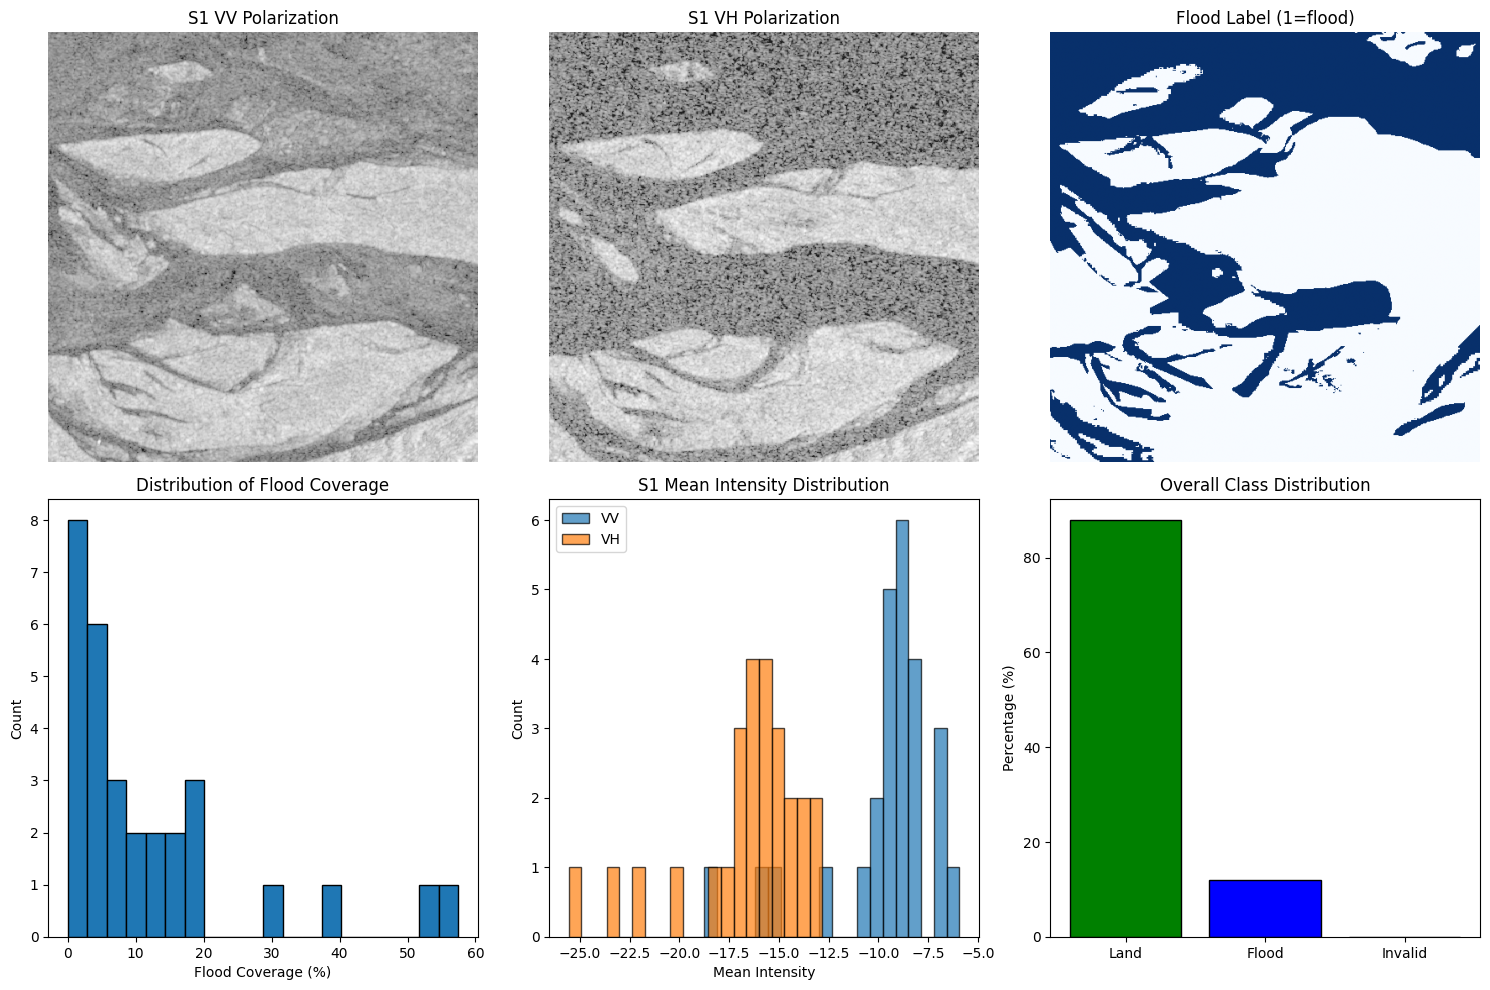

Visualization saved to: /content/sen1floods11_subset/eda_visualization.png


In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Sample visualization
with rasterio.open(s1_files[0]) as src:
    s1_sample = src.read()
with rasterio.open(label_files[0]) as src:
    label_sample = src.read(1)

axes[0, 0].imshow(s1_sample[0], cmap='gray')
axes[0, 0].set_title('S1 VV Polarization')
axes[0, 0].axis('off')

axes[0, 1].imshow(s1_sample[1], cmap='gray')
axes[0, 1].set_title('S1 VH Polarization')
axes[0, 1].axis('off')

# Mask out invalid pixels for visualization
label_vis = np.where(label_sample == 255, np.nan, label_sample)
axes[0, 2].imshow(label_vis, cmap='Blues', vmin=0, vmax=1)
axes[0, 2].set_title('Flood Label (1=flood)')
axes[0, 2].axis('off')

# Distribution plots
axes[1, 0].hist(flood_percentages, bins=20, edgecolor='black')
axes[1, 0].set_xlabel('Flood Coverage (%)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Flood Coverage')

axes[1, 1].hist(s1_stats['vv_mean'], bins=20, alpha=0.7, label='VV', edgecolor='black')
axes[1, 1].hist(s1_stats['vh_mean'], bins=20, alpha=0.7, label='VH', edgecolor='black')
axes[1, 1].set_xlabel('Mean Intensity')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('S1 Mean Intensity Distribution')
axes[1, 1].legend()

# Class balance
valid_pixels = 100 - np.mean(invalid_percentages)
flood_pixels_valid = np.mean(flood_percentages)
land_pixels_valid = valid_pixels - flood_pixels_valid

axes[1, 2].bar(['Land', 'Flood', 'Invalid'],
               [land_pixels_valid, flood_pixels_valid, np.mean(invalid_percentages)],
               color=['green', 'blue', 'gray'], edgecolor='black')
axes[1, 2].set_ylabel('Percentage (%)')
axes[1, 2].set_title('Overall Class Distribution')

plt.tight_layout()
plt.savefig(DATA_ROOT / 'eda_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Visualization saved to: {DATA_ROOT / 'eda_visualization.png'}")

### Train/Validation/Test Split

Since we are not using the full dataset, we have to split the data ourselves.

In [48]:
# Get valid pairs
valid_ids = list(set(s1_ids) & set(label_ids))
valid_ids.sort()

np.random.seed(42)
np.random.shuffle(valid_ids)

# Split: 70% train, 15% val, 15% test
n_total = len(valid_ids)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_ids = valid_ids[:n_train]
val_ids = valid_ids[n_train:n_train + n_val]
test_ids = valid_ids[n_train + n_val:]

print(f"\nTotal samples: {n_total}")
print(f"Train: {len(train_ids)} ({len(train_ids)/n_total*100:.1f}%)")
print(f"Val: {len(val_ids)} ({len(val_ids)/n_total*100:.1f}%)")
print(f"Test: {len(test_ids)} ({len(test_ids)/n_total*100:.1f}%)")

# Save splits
splits = {
    'train': train_ids,
    'val': val_ids,
    'test': test_ids
}

splits_path = DATA_ROOT / 'data_splits.json'
with open(splits_path, 'w') as f:
    json.dump(splits, f, indent=2)

print(f"\nSplits saved to: {splits_path}")


Total samples: 30
Train: 21 (70.0%)
Val: 4 (13.3%)
Test: 5 (16.7%)

Splits saved to: /content/sen1floods11_subset/data_splits.json


# Methodology

Segmentation with transfer learning allows us to generate pixel-level flood maps using only a small number of labeled Sentinel-1 images. Instead of training a model from scratch which would require thousands of examples, we start from a pretrained CNN that has already learn general image features.




In [49]:
# Define model: U-Net with ResNet34 Encoder

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=2,              # Sentinel-2 uses VV and VH
    classes=1                   # binary segmentation mask
)

In [50]:
# Freeze encoder, we train only the decoder/head first
for param in model.encoder.parameters():
  param.requires_grad = False

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

train_ds = Sentinel1FloodDataset(train_ids, S1_DIR, LABEL_IMG_DIR)
val_ds   = Sentinel1FloodDataset(val_ids,   S1_DIR, LABEL_IMG_DIR)
test_ds  = Sentinel1FloodDataset(test_ids,  S1_DIR, LABEL_IMG_DIR)

batch_size = 4

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [51]:
criterion = nn.BCEWithLogitsLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [52]:
def train_one_epoch():
    model.train()
    total_loss = 0.0
    batches = 0

    for x, y, valid in train_dl:
        x = x.to(device)
        y = y.to(device)
        valid = valid.to(device)   # (B,1,H,W) bool

        optimizer.zero_grad()
        logits = model(x)          # (B,1,H,W)

        # flatten only valid pixels
        if valid.sum() == 0:
            continue  # skip batch with no valid pixels

        loss = criterion(
            logits[valid],   # 1D vector of valid logits
            y[valid]         # 1D vector of valid labels
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1

    return total_loss / max(batches, 1)


def validate_one_epoch():
    model.eval()
    total_loss = 0.0
    batches = 0

    with torch.no_grad():
        for x, y, valid in val_dl:
            x = x.to(device)
            y = y.to(device)
            valid = valid.to(device)

            logits = model(x)

            if valid.sum() == 0:
                continue

            loss = criterion(logits[valid], y[valid])

            total_loss += loss.item()
            batches += 1

    return total_loss / max(batches, 1)

In [53]:
print("Training decoder with frozen encoder")
for epoch in range(3):
    train_loss = train_one_epoch()
    val_loss = validate_one_epoch()
    print(f"Epoch {epoch+1}: train = {train_loss:.4f} | val = {val_loss:.4f}")

Training decoder with frozen encoder
Epoch 1: train = 0.5646 | val = 0.7266
Epoch 2: train = 0.4094 | val = 0.5948
Epoch 3: train = 0.3266 | val = 0.5124


In [54]:
def eval_test_iou():
    model.eval()
    ious = []

    with torch.no_grad():
        for x, y, valid in test_dl:
            x = x.to(device)
            y = y.to(device)
            valid = valid.to(device)

            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            # compute IoU only on valid pixels
            v = valid.bool()
            if v.sum() == 0:
                continue

            pred_v = preds[v]
            y_v = y[v]

            intersection = (pred_v * y_v).sum()
            union = pred_v.sum() + y_v.sum() - intersection
            iou = (intersection / (union + 1e-6)).item()
            ious.append(iou)

    return sum(ious) / len(ious)

test_iou = eval_test_iou()
print(f"\nFinal Test IoU (valid pixels only): {test_iou:.4f}")


Final Test IoU (valid pixels only): 0.3889


Our result shows that it overlaps with the ground truth by 26% on average across valid pixels.

We then fine-tune this model to our segmentation task: distinguishing flooded from non-flooded areas in radar imaginery.

### Transfer Learning and Fine-Tuning

Transfer learning is the general idea of reusing a model trained on one dataset (e.g., ImageNet) to accelerate or improve learning on a new task (e.g., SAR flood segmentation). This can involve freezing the pretrained layers and training only a new task-specific head.

Fine-tuning is a specific form of transfer learning in which we unfreeze some or all of the pretrained layers and continue updating them on the new task. Fine-tuning allows the model to adapt its internal representations to the new domain.

In this demo:
- Training the U-Net decoder while the encoder is frozen shows basic transfer learning.
- Unfreezing the encoder and training the full network shows fine-tuning.
- Comparing both against a baseline CNN trained from scratch illustrates why transfer learning helps, and why fine-tuning usually performs even better—especially when the pretrained features are not naturally aligned with the new data domain.

### Fine-Tune the Encoder

Now that the decoder has been trained with a frozen encoder,
we unfreeze the encoder and fine-tune the full U-Net model.
This demonstrates the principle of transfer learning:
starting from an ImageNet encoder and adapting it to SAR data.

In [55]:
# Unfreeze encoder
for param in model.encoder.parameters():
    param.requires_grad = True

optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-4)

print("\nFine-tuning entire model (encoder + decoder):")

for epoch in range(3):
    train_loss = train_one_epoch()
    val_loss = validate_one_epoch()
    print(f"Fine-tune Epoch {epoch+1}: train={train_loss:.4f} | val={val_loss:.4f}")

ft_test_iou = eval_test_iou()
print(f"\nTest IoU after fine-tuning: {ft_test_iou:.4f}")


Fine-tuning entire model (encoder + decoder):
Fine-tune Epoch 1: train=0.2734 | val=0.4750
Fine-tune Epoch 2: train=0.2610 | val=0.3959
Fine-tune Epoch 3: train=0.2344 | val=0.3812

Test IoU after fine-tuning: 0.3951


Here we visualise the predictions.

We visualize:
1. The SAR VV/VH channels
2. Ground truth flood mask
3. Model prediction

This demonstrates not only performance, but also qualitative
generalisation ability.

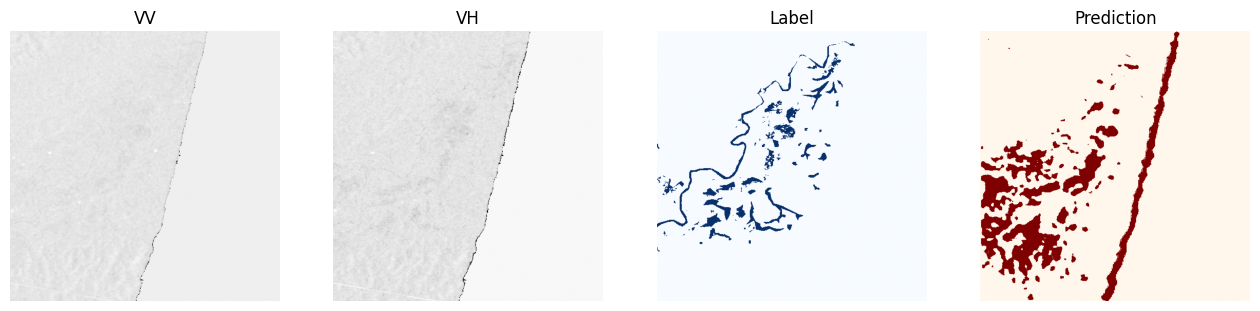

In [56]:
#Visualise
import matplotlib.pyplot as plt

model.eval()

def visualize_prediction(idx=0):
    cid = test_ids[idx]
    ds = Sentinel1FloodDataset([cid], S1_DIR, LABEL_IMG_DIR)
    x, y, valid = ds[0]

    x_in = x.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x_in)
        probs = torch.sigmoid(logits)[0,0].cpu().numpy()

    pred_mask = (probs > 0.5).astype(float)

    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    axes[0].imshow(x[0], cmap='gray'); axes[0].set_title("VV")
    axes[1].imshow(x[1], cmap='gray'); axes[1].set_title("VH")
    axes[2].imshow(y[0], cmap='Blues'); axes[2].set_title("Label")
    axes[3].imshow(pred_mask, cmap='OrRd'); axes[3].set_title("Prediction")

    for a in axes: a.axis('off')
    plt.show()

visualize_prediction(0)

### What happens if we transfer to a different encoder?

To demonstrate transfer learning architectures,
we train a second U-Net with a different ImageNet backbone
(EfficientNet-B0). This shows how encoder choice changes
performance and generalisation.

In [57]:
#Try different encoder

model_eff = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=2,
    classes=1
).to(device)

optimizer_eff = torch.optim.Adam(model_eff.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

def train_one_epoch_eff():
    model_eff.train()
    total = 0; batches=0
    for x,y,valid in train_dl:
        x=x.to(device); y=y.to(device); valid=valid.to(device)
        optimizer_eff.zero_grad()
        logits = model_eff(x)
        if valid.sum()==0: continue
        loss = criterion(logits[valid], y[valid])
        loss.backward()
        optimizer_eff.step()
        total += loss.item(); batches+=1
    return total/max(batches,1)

print("\nTraining U-Net w/ EfficientNet-B0 encoder")

for ep in range(2):
    loss = train_one_epoch_eff()
    print(f"Epoch {ep+1}: loss={loss:.4f}")


Training U-Net w/ EfficientNet-B0 encoder
Epoch 1: loss=0.5865
Epoch 2: loss=0.4286


### What if we compare this to a baseline model?

Shallow CNN Model (No Transfer Learning)

To understand the effect of transfer learning,
we train a simple baseline segmentation model from scratch.

This model:
- has no pretrained encoder
- is much smaller than U-Net
- uses only a few convolution layers
- serves as a ‘non-transfer-learning’ benchmark

We compare its performance (IoU) to the fine-tuned U-Net.

In [58]:
import torch.nn as nn

class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)  # downsample
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # Decoder
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv_out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.up(x)
        x = self.conv_out(x)
        return x


baseline_model = BaselineCNN().to(device)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
baseline_criterion = nn.BCEWithLogitsLoss()


def train_one_epoch_baseline():
    baseline_model.train()
    total_loss = 0; batches = 0

    for x, y, valid in train_dl:
        x = x.to(device); y = y.to(device); valid = valid.to(device)
        baseline_optimizer.zero_grad()

        logits = baseline_model(x)

        if valid.sum() == 0:
            continue

        loss = baseline_criterion(logits[valid], y[valid])
        loss.backward()
        baseline_optimizer.step()

        total_loss += loss.item()
        batches += 1

    return total_loss / max(batches, 1)


def evaluate_baseline_iou():
    baseline_model.eval()
    ious = []

    with torch.no_grad():
        for x, y, valid in test_dl:
            x = x.to(device); y = y.to(device); valid = valid.to(device)

            logits = baseline_model(x)
            preds = (torch.sigmoid(logits) > 0.5).float()

            v = valid.bool()
            if v.sum() == 0: continue

            pv = preds[v]; yv = y[v]

            intersection = (pv * yv).sum()
            union = pv.sum() + yv.sum() - intersection

            ious.append((intersection / (union + 1e-6)).item())

    return sum(ious) / len(ious)


print("\nTraining baseline CNN model (no transfer learning)...")
for ep in range(3):
    loss = train_one_epoch_baseline()
    print(f"Baseline Epoch {ep+1}: loss={loss:.4f}")

baseline_iou = evaluate_baseline_iou()
print(f"\n Baseline Test IoU: {baseline_iou:.4f}")

print("\n Final Comparison:")
print(f"  Baseline CNN        : IoU = {baseline_iou:.4f}")
print(f"  Fine-tuned U-Net    : IoU = {ft_test_iou:.4f}")


Training baseline CNN model (no transfer learning)...
Baseline Epoch 1: loss=0.6615
Baseline Epoch 2: loss=0.6110
Baseline Epoch 3: loss=0.6110

 Baseline Test IoU: 0.3681

 Final Comparison:
  Baseline CNN        : IoU = 0.3681
  Fine-tuned U-Net    : IoU = 0.3951
